In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from models.NeuralMSM import NeuralMSM
import torch
from scipy import stats, signal, ndimage
from matplotlib.ticker import FuncFormatter

## Awake

In [2]:
path = 'data/neuroscience/monkey_awake_test_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()
num_states = 15
num_lags = 2
model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
obs = data_awake[:]
local_evidence = model._compute_local_evidence(obs.to(model.device))
alpha, log_Z = model._forward(local_evidence)
beta = model._backward(local_evidence, log_Z)
gamma_awake = model._compute_marginals(alpha, beta)
print(gamma_awake.size())

torch.Size([50, 399, 15])


In [10]:
signal.medfilt(gamma_awake.cpu().detach().numpy(), kernel_size=3)
gamma_awake_smooth = ndimage.convolve1d(gamma_awake.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
gamma_awake_smooth /= gamma_awake_smooth.sum(-1,keepdims=True)

In [86]:
(gamma_awake_smooth.sum(1).mean(0)> 1).sum()

9

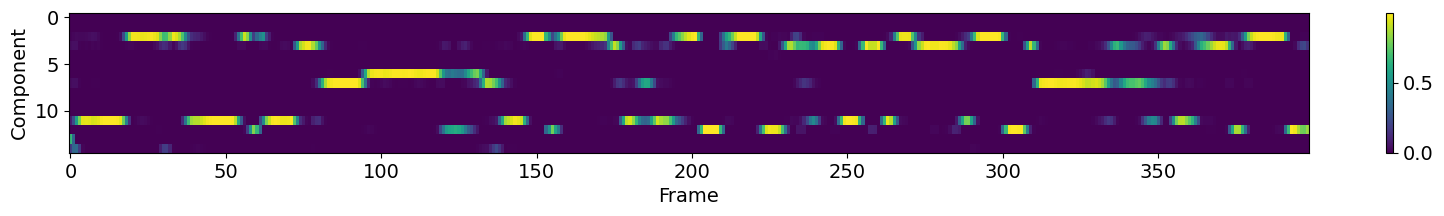

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,4))
plt.subplot(211)
plt.imshow(gamma_awake_smooth[0].T, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Component')
plt.colorbar()

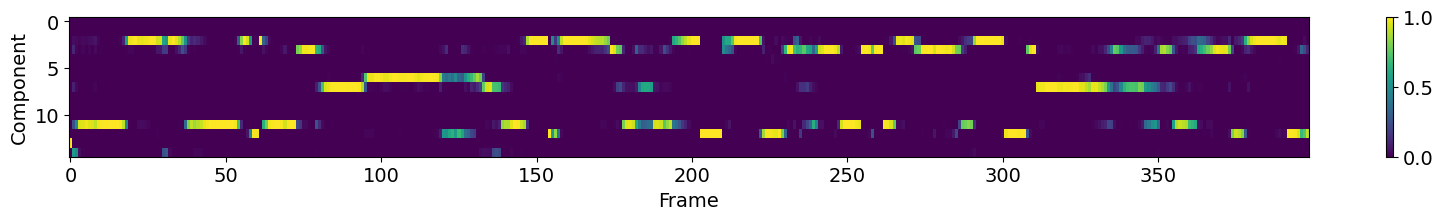

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,4))
plt.subplot(211)
plt.imshow(gamma_awake[0,:400].cpu().detach().numpy().T, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Component')
plt.colorbar()

## Sleep

In [134]:
path = '../data/neuroscience/monkey_sleep_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()
num_states = 15
num_lags = 2
model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
obs = data_awake[:]
local_evidence = model._compute_local_evidence(obs.to(model.device))
alpha, log_Z = model._forward(local_evidence)
beta = model._backward(local_evidence, log_Z)
gamma_sleep = model._compute_marginals(alpha, beta)
gamma_sleep_smooth = ndimage.convolve1d(gamma_sleep.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
gamma_sleep_smooth /= gamma_sleep_smooth.sum(-1,keepdims=True)
print(gamma_sleep.size())

torch.Size([325, 399, 15])


In [42]:
idxs = np.where((gamma_sleep.cpu().detach().numpy().sum(1) > 1)[0])[0]
print(gamma_sleep_smooth[0][:,idxs].shape)

(399, 5)


In [44]:
idxs

array([ 0,  1,  8,  9, 13])

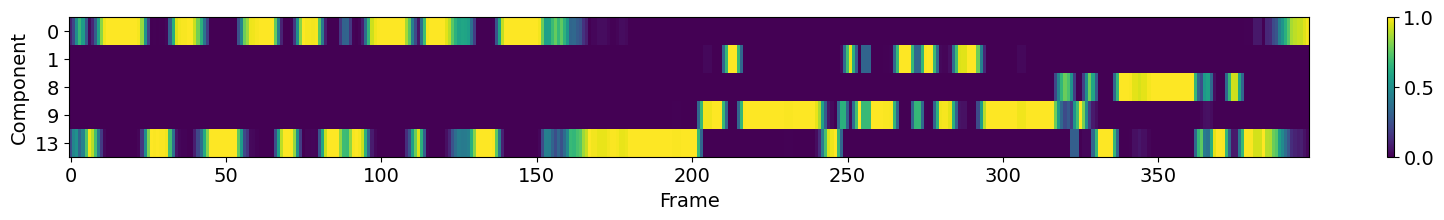

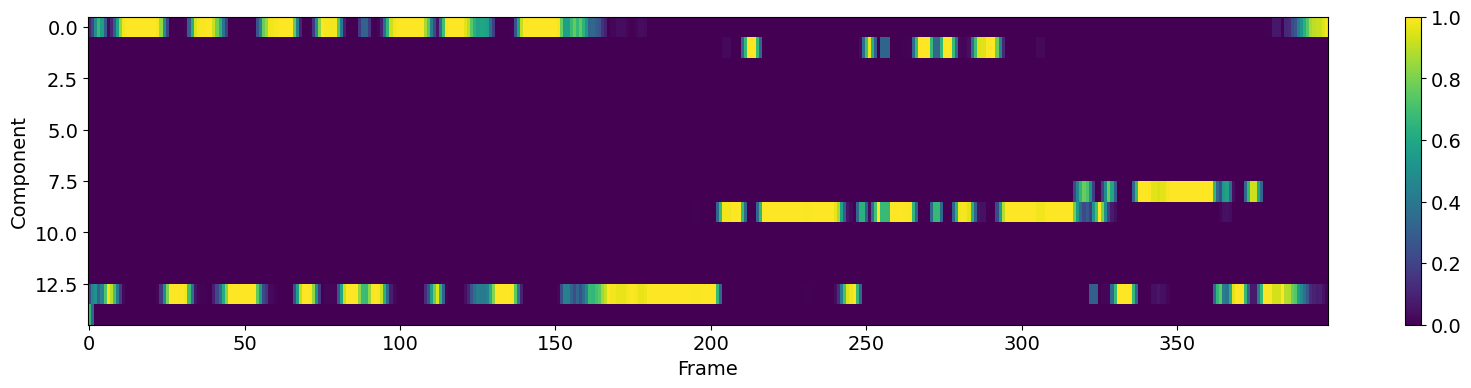

In [46]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,4))
plt.subplot(211)
idxs = np.where((gamma_sleep.cpu().detach().numpy().sum(1) > 1)[0])[0]
plt.imshow(gamma_sleep_smooth[0][...,idxs].T, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Component')
plt.yticks(range(len(idxs)), idxs)
plt.colorbar()
plt.show()
plt.figure(figsize=(20,4))
plt.imshow(gamma_sleep_smooth[0].T, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Component')
plt.colorbar()
plt.show()

/tmp/ipykernel_3978526/1882100521.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/ipykernel_3978526/1882100521.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.linspace(0.,2, 9, endpoint=True))


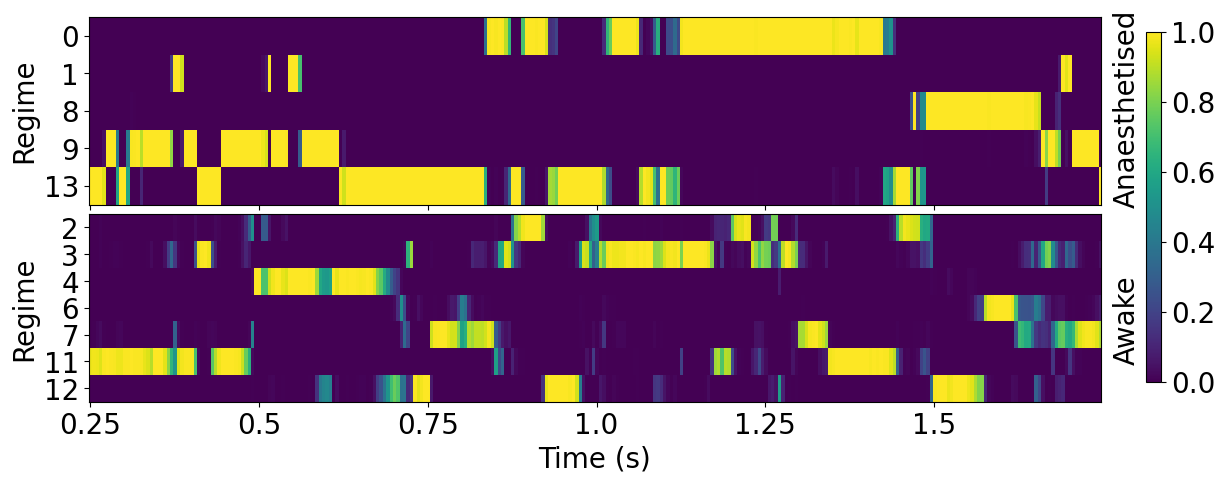

In [135]:
import matplotlib
B = 30
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(15,5))
plt.tight_layout()
ax = plt.subplot(211)

idxs = np.where((gamma_sleep.cpu().detach().numpy().sum(1) > 4)[B])[0]

plt.imshow(gamma_sleep[B,50:350, idxs].cpu().detach().numpy().T, aspect='auto')
plt.ylabel('Regime')
ax.set_yticks(range(len(idxs)), idxs)
ax.set_xticklabels([''])

ax = plt.subplot(212)
idxs = np.where((gamma_awake.cpu().detach().numpy().sum(1) > 4)[B])[0]

im = plt.imshow(gamma_awake[B,50:350, idxs].cpu().detach().numpy().T, aspect='auto')

plt.xlabel('Time (s)')
plt.ylabel('Regime')
ax.set_yticks(range(len(idxs)), idxs)
ax.set_xticklabels(np.linspace(0.,2, 9, endpoint=True))
plt.text(303, -0.95, 'Anaesthetised', rotation='vertical')
plt.text(303, 4.9, 'Awake', rotation='vertical')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(hspace=0.05)
plt.savefig('example_neuroscience_data.pdf', bbox_inches='tight')

## State utilisation and state transition frequency

In [2]:
awake_freq_data = []
awake_state_util_data = []
sleep_freq_data = []
sleep_state_util_data = []
awake_log_Z_data = []
sleep_log_Z_data = []
#num_lags = 2
num_states = 10
for num_lags in [1, 2, 5, 10 ,20]:
    path = 'data/neuroscience/monkey_awake_test_visual_cortex.npy'
    data_awake = torch.from_numpy(np.load(path)).float()
    model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
    model.to(model.device)
    obs = data_awake[:]
    local_evidence = model._compute_local_evidence(obs.to(model.device))
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma_awake = model._compute_marginals(alpha, beta)
    awake_log_Z_data.append(log_Z.sum(-1).mean().item())
    awake_freq_change_list = []
    awake_state_utilisation_list = []
    for i in range(gamma_awake.shape[0]):
        awake_freq_change_list.append(len(gamma_awake[i].argmax(-1).unique_consecutive())/2.)
        _, pk = gamma_awake[i].argmax(-1).unique(return_counts=True)
        awake_state_utilisation_list.append(stats.entropy(pk.cpu().numpy()))
    
    awake_freq_change_list = np.array(awake_freq_change_list)
    awake_state_utilisation_list = np.array(awake_state_utilisation_list)

    path = '../data/neuroscience/monkey_sleep_test_visual_cortex.npy'
    data_sleep = torch.from_numpy(np.load(path)).float()
    model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
    model.to(model.device)
    obs = data_sleep[:]
    local_evidence = model._compute_local_evidence(obs.to(model.device))
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma_sleep = model._compute_marginals(alpha, beta)
    gamma_sleep_smooth = ndimage.convolve1d(gamma_sleep.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
    gamma_sleep_smooth /= gamma_sleep_smooth.sum(-1,keepdims=True)
    gamma_sleep_smooth = torch.from_numpy(gamma_sleep_smooth)
    sleep_log_Z_data.append(log_Z.sum(-1).mean().item())
    sleep_freq_change_list = []
    sleep_state_utilisation_list = []
    for i in range(gamma_sleep.shape[0]):
        sleep_freq_change_list.append(len(gamma_sleep_smooth[i].argmax(-1).unique_consecutive())/2.)
        _, pk = gamma_sleep_smooth[i].argmax(-1).unique(return_counts=True)
        sleep_state_utilisation_list.append(stats.entropy(pk.cpu().numpy()))
    sleep_freq_change_list = np.array(sleep_freq_change_list)
    sleep_state_utilisation_list = np.array(sleep_state_utilisation_list)

    awake_freq_data.append(awake_freq_change_list.mean())
    sleep_freq_data.append(sleep_freq_change_list.mean())

    awake_state_util_data.append(awake_state_utilisation_list.mean())
    sleep_state_util_data.append(sleep_state_utilisation_list.mean())

## Table info

In [49]:
def max_state_duration(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, T) tensor with discrete states (e.g. integers)
    Returns: (B,) tensor with max duration (longest run length) per sample
    """
    B, T = x.shape

    # Mark run starts
    is_start = torch.ones((B, T), dtype=torch.bool)
    is_start[:, 1:] = x[:, 1:] != x[:, :-1]

    # Run ids per row
    run_id = is_start.cumsum(dim=1) - 1
    global_id = run_id + (torch.arange(B, device=x.device).view(B, 1) * T)

    # Count length of each run
    counts = torch.bincount(global_id.reshape(-1), minlength=B * T)
    counts_per_row = counts.view(B, T)

    # Max run length for each sequence
    return counts_per_row.max(dim=1).values

num_lags = 2
num_states = 15
path = 'data/neuroscience/monkey_awake_test_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()
model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
obs = data_awake[:]
local_evidence = model._compute_local_evidence(obs.to(model.device))
alpha, log_Z = model._forward(local_evidence)
beta = model._backward(local_evidence, log_Z)
gamma_awake = model._compute_marginals(alpha, beta)
gamma_awake_smooth = ndimage.convolve1d(gamma_awake.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
gamma_awake_smooth /= gamma_awake_smooth.sum(-1,keepdims=True)
gamma_awake_smooth = torch.from_numpy(gamma_awake_smooth)

awake_freq_change_list = []
for i in range(gamma_awake.shape[0]):
    awake_freq_change_list.append(len(gamma_awake_smooth[i].argmax(-1).unique_consecutive())/2.)

awake_freq_change_list = np.array(awake_freq_change_list)
awake_freq_change = awake_freq_change_list.mean()
awake_usage_per_sample = 100*(gamma_awake_smooth.numpy().sum(1) > 4).sum(-1).mean()/num_states
awake_usage_per_sample_list = 100*(gamma_awake_smooth.numpy().sum(1) > 4).sum(-1)/num_states
awake_usage_total = 100*(gamma_awake_smooth.numpy().sum(1) > 4).any(0).mean()
awake_max_duration = max_state_duration(gamma_awake_smooth.argmax(-1)).float().mean().item()*2/400
awake_max_duration_list = max_state_duration(gamma_awake_smooth.argmax(-1)).float()*2/400

path = '../data/neuroscience/monkey_sleep_test_visual_cortex.npy'
data_sleep = torch.from_numpy(np.load(path)).float()
model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
obs = data_sleep[:]
local_evidence = model._compute_local_evidence(obs.to(model.device))
alpha, log_Z = model._forward(local_evidence)
beta = model._backward(local_evidence, log_Z)
gamma_sleep = model._compute_marginals(alpha, beta)
gamma_sleep_smooth = ndimage.convolve1d(gamma_sleep.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
gamma_sleep_smooth /= gamma_sleep_smooth.sum(-1,keepdims=True)
gamma_sleep_smooth = torch.from_numpy(gamma_sleep_smooth)

sleep_freq_change_list = []
for i in range(gamma_sleep.shape[0]):
    sleep_freq_change_list.append(len(gamma_sleep_smooth[i].argmax(-1).unique_consecutive())/2.)
sleep_freq_change_list = np.array(sleep_freq_change_list)
sleep_freq_change = sleep_freq_change_list.mean()
sleep_usage_per_sample = 100*(gamma_sleep_smooth.numpy().sum(1) > 4).sum(-1).mean()/num_states
sleep_usage_per_sample_list = 100*(gamma_sleep_smooth.numpy().sum(1) > 4).sum(-1)/num_states
sleep_usage_total = 100*(gamma_sleep_smooth.numpy().sum(1) > 4).any(0).mean()
sleep_max_duration = max_state_duration(gamma_sleep_smooth.argmax(-1)).float().mean().item()*2/400
sleep_max_duration_list = max_state_duration(gamma_sleep_smooth.argmax(-1)).float()*2/400


In [50]:
print(awake_freq_change, awake_usage_total, awake_usage_per_sample, awake_max_duration)
print(sleep_freq_change, sleep_usage_total, sleep_usage_per_sample, sleep_max_duration)

import numpy as np
from scipy import stats  # if available

def mean_ci(x, alpha=0.05):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]               # optional: drop NaNs
    n = x.size
    mean = x.mean()
    s = x.std(ddof=1)                 # sample std
    t = stats.t.ppf(1 - alpha/2, df=n-1)
    half_width = t * s / np.sqrt(n)
    return mean, half_width

print(
    mean_ci(awake_freq_change_list),'\n',
    mean_ci(awake_usage_per_sample_list),'\n',
    mean_ci(awake_max_duration_list),'\n',
    mean_ci(sleep_freq_change_list),'\n',
    mean_ci(sleep_usage_per_sample_list),'\n',
    mean_ci(sleep_max_duration_list),
)


22.05 53.333333333333336 44.13333333333333 0.2215999984741211
17.71 33.33333333333333 26.4 0.35459999084472654
(22.05, 1.0626888779791532) 
 (44.13333333333332, 1.4770401997737748) 
 (0.22159999951720238, 0.020900765091349204) 
 (17.71, 1.2877451748298192) 
 (26.400000000000006, 1.4805080165203268) 
 (0.3545999997854233, 0.03806068803104647)


## Num Lags Graph

In [3]:
awake_freq_data = []
awake_state_util_data = []
sleep_freq_data = []
sleep_state_util_data = []
awake_log_Z_data = []
sleep_log_Z_data = []
#num_lags = 2
num_states = 10
for num_lags in [1, 2, 5, 10 ,20]:
    path = 'data/neuroscience/monkey_awake_test_visual_cortex.npy'
    data_awake = torch.from_numpy(np.load(path)).float()
    model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
    model.to(model.device)
    obs = data_awake[:]
    local_evidence = model._compute_local_evidence(obs.to(model.device))
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma_awake = model._compute_marginals(alpha, beta)
    awake_log_Z_data.append(log_Z.sum(-1).mean().item())
    awake_freq_change_list = []
    awake_state_utilisation_list = []
    for i in range(gamma_awake.shape[0]):
        awake_freq_change_list.append(len(gamma_awake[i].argmax(-1).unique_consecutive())/2.)
        _, pk = gamma_awake[i].argmax(-1).unique(return_counts=True)
        awake_state_utilisation_list.append(stats.entropy(pk.cpu().numpy()))
    
    awake_freq_change_list = np.array(awake_freq_change_list)
    awake_state_utilisation_list = np.array(awake_state_utilisation_list)

    path = '../data/neuroscience/monkey_sleep_test_visual_cortex.npy'
    data_sleep = torch.from_numpy(np.load(path)).float()
    model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
    model.to(model.device)
    obs = data_sleep[:]
    local_evidence = model._compute_local_evidence(obs.to(model.device))
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma_sleep = model._compute_marginals(alpha, beta)
    gamma_sleep_smooth = ndimage.convolve1d(gamma_sleep.cpu().detach().numpy(), weights=[1/3]*3, axis=1)
    gamma_sleep_smooth /= gamma_sleep_smooth.sum(-1,keepdims=True)
    gamma_sleep_smooth = torch.from_numpy(gamma_sleep_smooth)
    sleep_log_Z_data.append(log_Z.sum(-1).mean().item())
    sleep_freq_change_list = []
    sleep_state_utilisation_list = []
    for i in range(gamma_sleep.shape[0]):
        sleep_freq_change_list.append(len(gamma_sleep_smooth[i].argmax(-1).unique_consecutive())/2.)
        _, pk = gamma_sleep_smooth[i].argmax(-1).unique(return_counts=True)
        sleep_state_utilisation_list.append(stats.entropy(pk.cpu().numpy()))
    sleep_freq_change_list = np.array(sleep_freq_change_list)
    sleep_state_utilisation_list = np.array(sleep_state_utilisation_list)

    awake_freq_data.append(awake_freq_change_list.mean())
    sleep_freq_data.append(sleep_freq_change_list.mean())

    awake_state_util_data.append(awake_state_utilisation_list.mean())
    sleep_state_util_data.append(sleep_state_utilisation_list.mean())

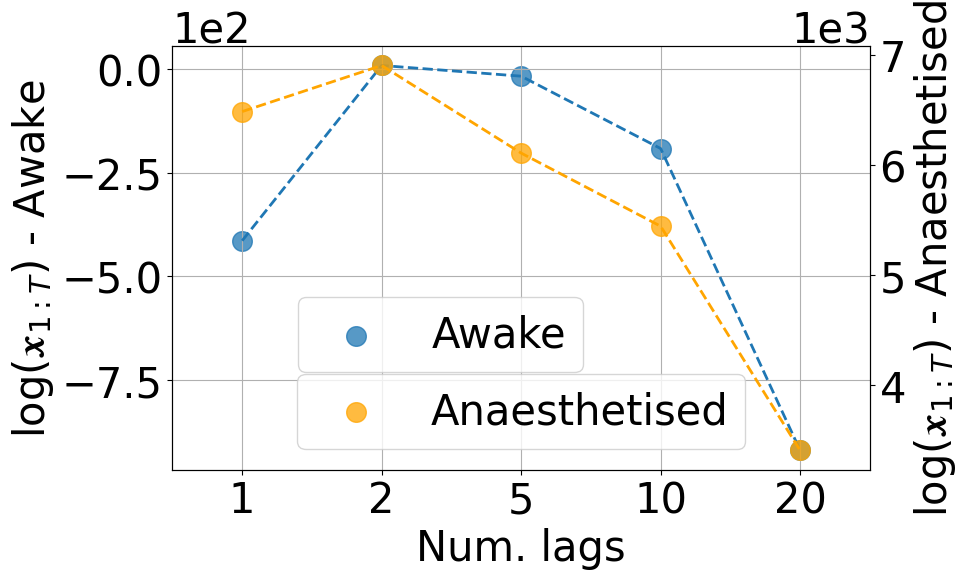

In [18]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

matplotlib.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(9,5.5))


# set the number of rows and cols for our table
x_labels = 5
xs = range(x_labels)
# create a coordinate system based on the number of rows/columns
labels = [1, 2, 5, 10, 20][:x_labels]
# adding a bit of padding on bottom (-1), top (1), right (0.5)

ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.set_xlim(-0.5,x_labels-.5)
ax.set_xlabel("Num. lags")

ax.set_ylabel("$\\log(𝒙_{1:T})$ - Awake")

ax.plot(range(x_labels),awake_log_Z_data, '--',linewidth=2)
ax.scatter(range(x_labels),awake_log_Z_data, s=200, label="Awake", alpha=0.75)
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,2))
ax2 = ax.twinx()
ax2.set_ylabel("$\\log(𝒙_{1:T})$ - Anaesthetised")
ax2.plot(range(x_labels),sleep_log_Z_data, '--', color='orange', linewidth=2)
ax2.scatter(range(x_labels),sleep_log_Z_data, color='orange', s=200, label="Anaesthetised", alpha=0.75)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(1,2))
ax.legend(loc=(0.18,0.23))
ax2.legend(loc='lower center')
ax.grid()

plt.savefig('neuroscience_log_likelihood.pdf',bbox_inches='tight')

In [224]:
stats.entropy([0.5, 0.5, 0.5, 0.5, 0.5])

1.6094379124341005

In [217]:
_, pk = gamma_awake[0].argmax(-1).unique(return_counts=True)
stats.entropy(pk.cpu().numpy())

1.1051970783939418

## Jacobian

In [196]:

path = '../neuroscience/monkey_awake_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()
dim_obs = 21
num_states = 5
num_lags = 2
model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
jacobis = [torch.zeros((dim_obs,num_lags*dim_obs)).to(model.device) for k in range(num_states)]
obs = data_awake[:].to(model.device)
with torch.no_grad():
    local_evidence = model._compute_local_evidence(obs)
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma = model._compute_marginals(alpha, beta)
    seasons = gamma.argmax(dim=-1).reshape(-1)
    _, counts = seasons.unique(return_counts=True)
counts = [0]*num_states
#for i, idx in enumerate(idxs):
#    counts[idx] = counts_ids[i].item()
points = obs
N, T, _ = points.shape

data_in = torch.cat([points[:,i:-num_lags+i,None,:] for i in range(num_lags)],dim=2).reshape(N,T-num_lags,-1).reshape(N*(T-num_lags),-1)
for l in range(5000):
    jacobis[seasons[l]] += torch.abs(torch.autograd.functional.jacobian(model.transitions[seasons[l]], data_in[l]))
    counts[seasons[l]] += 1
for k in range(num_states):
    if counts[k] != 0:
        jacobis[k] /= counts[k]
print(counts)
print((jacobis[0] > 5e-2).float().sum(-1))
print((jacobis[1] > 5e-2).float().sum(-1))
print((jacobis[2] > 5e-2).float().sum(-1))
print((jacobis[3] > 5e-2).float().sum(-1))
print((jacobis[4] > 5e-2).float().sum(-1))

[1106, 53, 1415, 2355, 71]
tensor([ 5.,  8.,  8.,  9., 12., 10.,  6., 11.,  8., 11.,  9.,  6.,  4., 11.,
         8.,  9.,  6.,  9., 11.,  9.,  7.], device='cuda:0')
tensor([31., 32., 17., 13., 33., 29., 28., 35., 21., 28., 31., 21., 38., 33.,
        26.,  7., 11., 37., 35., 16., 14.], device='cuda:0')
tensor([15., 16., 21., 19., 23., 17., 12., 12., 14., 16., 11.,  9., 19., 11.,
        17., 25., 21., 14., 19., 20., 24.], device='cuda:0')
tensor([ 5.,  7.,  9.,  8., 13.,  8.,  8., 13., 11.,  7.,  7.,  6.,  4.,  9.,
         6.,  6.,  6., 10.,  7.,  7.,  7.], device='cuda:0')
tensor([35., 27., 31., 29., 34., 25., 21., 31., 32., 32., 29., 31., 37., 31.,
        25., 31., 30., 26., 27., 27., 23.], device='cuda:0')


In [197]:
path = '../neuroscience/monkey_sleep_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()
dim_obs = 21
num_states = 5
num_lags = 2
model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
model.to(model.device)
jacobis = [torch.zeros((dim_obs,num_lags*dim_obs)).to(model.device) for k in range(num_states)]
obs = data_awake[:].to(model.device)
with torch.no_grad():
    local_evidence = model._compute_local_evidence(obs)
    alpha, log_Z = model._forward(local_evidence)
    beta = model._backward(local_evidence, log_Z)
    gamma = model._compute_marginals(alpha, beta)
    seasons = gamma.argmax(dim=-1).reshape(-1)
    idxs, counts_ids = seasons.unique(return_counts=True)
counts = [0]*num_states
#for i, idx in enumerate(idxs):
#    counts[idx] = counts_ids[i].item()
points = obs
N, T, _ = points.shape

data_in = torch.cat([points[:,i:-num_lags+i,None,:] for i in range(num_lags)],dim=2).reshape(N,T-num_lags,-1).reshape(N*(T-num_lags),-1)
for l in range(5000):
    jacobis[seasons[l]] += torch.abs(torch.autograd.functional.jacobian(model.transitions[seasons[l]], data_in[l]))
    counts[seasons[l]] += 1
for k in range(num_states):
    if counts[k] != 0:
        jacobis[k] /= counts[k]
print(counts)
print((jacobis[0] > 5e-2).float().sum(-1))
print((jacobis[1] > 5e-2).float().sum(-1))
print((jacobis[2] > 5e-2).float().sum(-1))
print((jacobis[3] > 5e-2).float().sum(-1))
print((jacobis[4] > 5e-2).float().sum(-1))

[128, 3101, 1709, 0, 62]
tensor([28., 29., 31., 28., 26., 29., 23., 29., 29., 24., 28., 25., 27., 21.,
        28., 24., 30., 28., 24., 28., 24.], device='cuda:1')
tensor([34., 27., 32., 36., 29., 29., 32., 30., 36., 33., 30., 31., 36., 32.,
        37., 34., 28., 38., 35., 37., 33.], device='cuda:1')
tensor([18., 26., 25., 19., 26., 33., 22., 16., 22., 14., 10., 13., 12., 31.,
        27., 29., 24., 34., 32., 29., 16.], device='cuda:1')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:1')
tensor([22., 20., 19., 19., 28., 16., 22., 25., 28., 29., 25., 26., 22., 22.,
        19., 22., 22., 23., 16., 19., 17.], device='cuda:1')


In [19]:
lags = [2]
regimes = [1, 3, 5, 10, 15, 20]
noise = 'const'
path = 'data/neuroscience/monkey_sleep_test_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()

log_data_sleep = []
for num_states in regimes:
    data_i = []
    for num_lags in lags:
        model = np.load('results/neuroscience/sleep_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
        model.to(model.device)
        for i in range(num_states):
            try:
                model.transitions[i].activation = model.transitions[i].act_func
            except:
                continue
        local_evidence = model._compute_local_evidence(data_awake.to(model.device))
        alpha, log_Z = model._forward(local_evidence)
        data_i.append(log_Z.sum(-1).mean().item())
    log_data_sleep.append(data_i)
log_data_sleep = np.array(log_data_sleep)

lags = [2]
regimes = [1, 3, 5, 10, 15, 20]
noise = 'const'
path = '../data/neuroscience/monkey_awake_test_visual_cortex.npy'
data_awake = torch.from_numpy(np.load(path)).float()

log_data_awake = []
for num_states in regimes:
    data_i = []
    for num_lags in lags:
        model = np.load('results/neuroscience/awake_num_states_{}_num_lags_{}_act_cos_exact_update.npy'.format(num_states,num_lags), allow_pickle=True).item()['arr']
        model.to(model.device)
        for i in range(num_states):
            try:
                model.transitions[i].activation = model.transitions[i].act_func
            except:
                continue
        local_evidence = model._compute_local_evidence(data_awake.to(model.device))
        alpha, log_Z = model._forward(local_evidence)
        data_i.append(log_Z.sum(-1).mean().item())
    log_data_awake.append(data_i)
log_data_awake = np.array(log_data_awake)


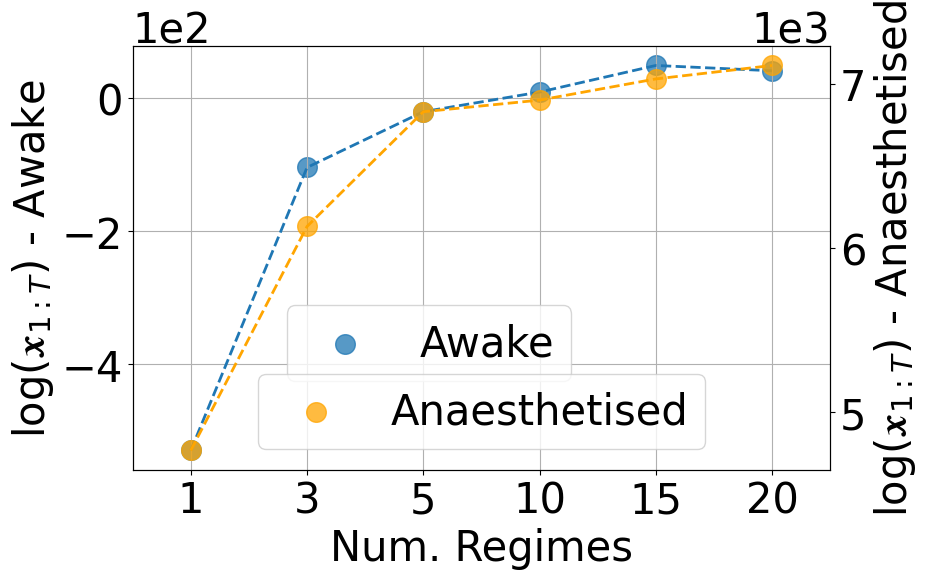

In [27]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

matplotlib.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(9,5.5))


# set the number of rows and cols for our table
x_labels = 6
xs = range(x_labels)
# create a coordinate system based on the number of rows/columns
labels = [1, 3, 5, 10, 15, 20][:x_labels]
# adding a bit of padding on bottom (-1), top (1), right (0.5)

ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.set_xlim(-0.5,x_labels-.5)
ax.set_xlabel("Num. Regimes")

ax.set_ylabel("$\\log(𝒙_{1:T})$ - Awake")

ax.plot(range(x_labels),log_data_awake, '--',linewidth=2)
ax.scatter(range(x_labels),log_data_awake, s=200, label="Awake", alpha=0.75)
ax.ticklabel_format(style='sci', axis='y', scilimits=(1,2))
ax2 = ax.twinx()
ax2.set_ylabel("$\\log(𝒙_{1:T})$ - Anaesthetised")
ax2.plot(range(x_labels),log_data_sleep, '--', color='orange', linewidth=2)
ax2.scatter(range(x_labels),log_data_sleep, color='orange', s=200, label="Anaesthetised", alpha=0.75)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(1,2))
ax.legend(loc=(0.221,0.21))
ax2.legend(loc='lower center')
ax.grid()

plt.savefig('log_likelihood_vs_regimes_neuroscience.pdf',bbox_inches='tight')

(4, 5)


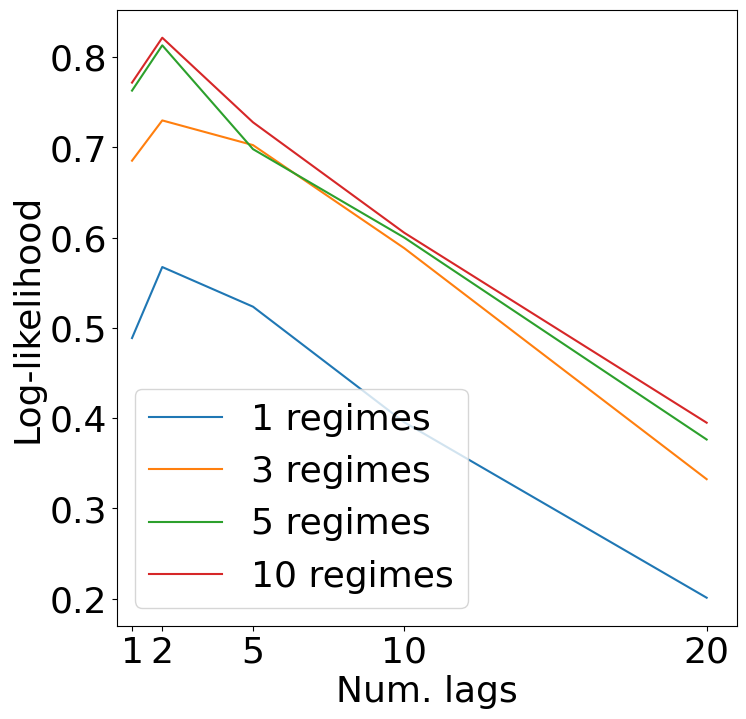

In [58]:
print(data.shape)
plt.figure(figsize=(8,8))
for i, num_states in enumerate(regimes):
    plt.plot(lags, data[i], label="{} regimes".format(num_states))
plt.xlim(0.5, 21)
plt.xticks(lags, lags)
plt.legend()
plt.xlabel("Num. lags")
plt.ylabel("Log-likelihood")
plt.show()